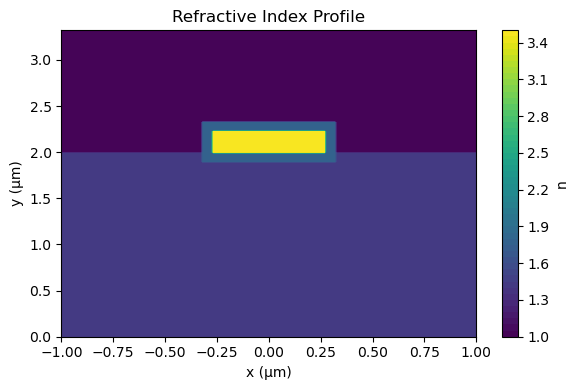

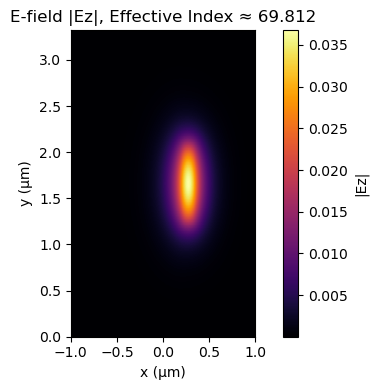

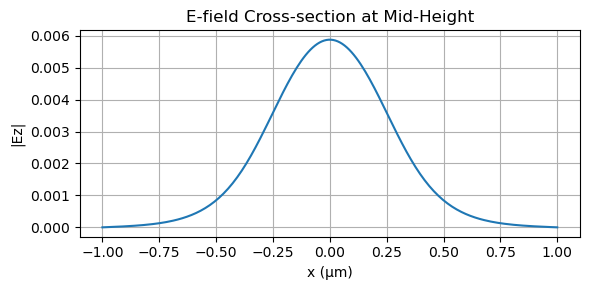

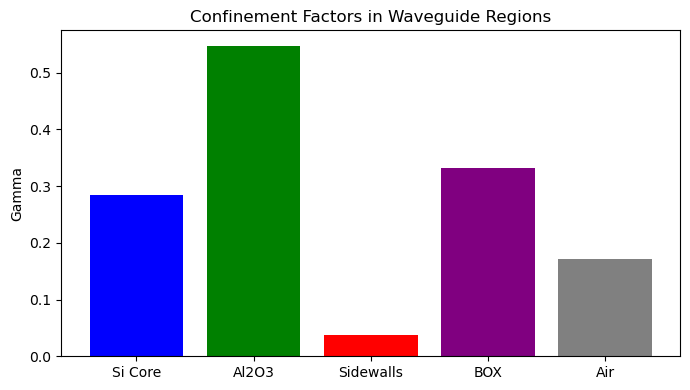

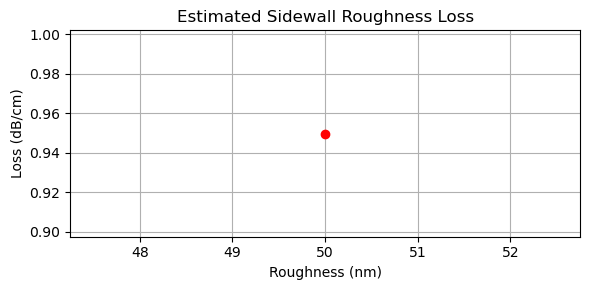

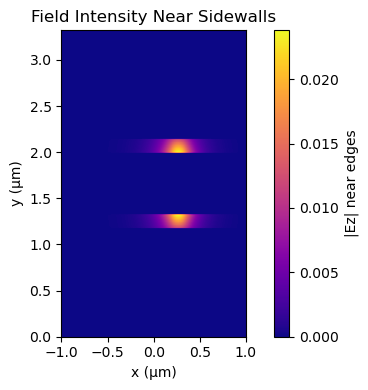

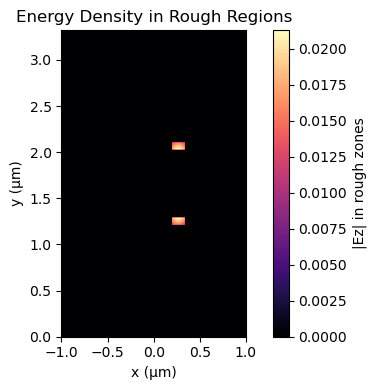

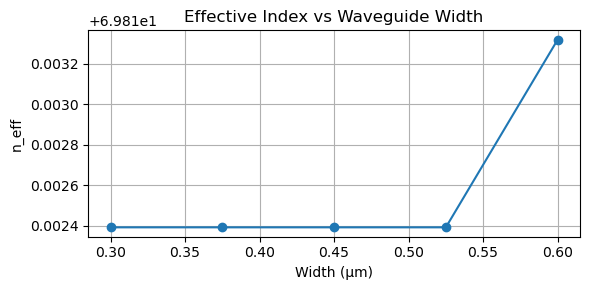

Effective Index (n_eff): 69.8124
Confinement in Silicon (Gamma_Si): 0.2845
Confinement in Al2O3 (Gamma_Al2O3): 0.5474
Confinement in Sidewalls (Gamma_Rough): 0.0380
Confinement in BOX (Gamma_BOX): 0.3325


<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import eigs

# Constants
wavelength = 1.55  # microns
k0 = 2 * np.pi / wavelength
grid_size = 200
dx = 0.01  # micron resolution

# Geometry parameters
W = 0.45         # Silicon core width
H = 0.22         # Silicon core height
t_Al2O3 = 0.1    # Al2O3 thickness
H_BOX = 2.0      # Buried oxide thickness
H_AIR = 1.0      # Air cladding thickness
roughness = 0.05 # Sidewall roughness

# Grid
x = np.linspace(-1, 1, grid_size)
y = np.linspace(0, H_BOX + H + t_Al2O3 + H_AIR, grid_size)
X, Y = np.meshgrid(x, y)

# Refractive index profile
n = np.ones_like(X)  # Air by default
n[Y < H_BOX] = 1.44  # BOX

# Silicon core
core_mask = (np.abs(X) < W/2) & (Y > H_BOX) & (Y < H_BOX + H)
n[core_mask] = 3.48

# Al2O3 conformal coating
al_mask = (np.abs(X) < W/2 + t_Al2O3) & (Y > H_BOX - t_Al2O3) & (Y < H_BOX + H + t_Al2O3)
n[al_mask & ~core_mask] = 1.76

# Sidewall roughness
rough_mask = (np.abs(X) > W/2) & (np.abs(X) < W/2 + roughness) & (Y > H_BOX) & (Y < H_BOX + H)
n[rough_mask] = 3.48

# Air cladding and BOX masks
air_mask = (Y > H_BOX + H + t_Al2O3)
box_mask = (Y < H_BOX)

# Plot 1: Refractive Index Profile
plt.figure(figsize=(6, 4))
plt.contourf(X, Y, n, levels=50, cmap='viridis')
plt.title('Refractive Index Profile')
plt.xlabel('x (μm)')
plt.ylabel('y (μm)')
plt.colorbar(label='n')
plt.tight_layout()
plt.show()

# Finite difference matrix setup
N = grid_size**2
n_flat = n.flatten()
V = (k0 * n_flat)**2

main_diag = -4 * np.ones(N)
side_diag = np.ones(N - 1)
side_diag[np.arange(1, N) % grid_size == 0] = 0
up_down_diag = np.ones(N - grid_size)

diagonals = [main_diag, side_diag, side_diag, up_down_diag, up_down_diag]
offsets = [0, -1, 1, -grid_size, grid_size]
L = diags(diagonals, offsets) / dx**2
H_matrix = -L + diags(V, 0)

# Solve for mode
vals, vecs = eigs(H_matrix, k=1, which='LR')
neff = np.sqrt(vals.real[0]) / k0
field = np.abs(vecs[:, 0].reshape(grid_size, grid_size))

# Plot 2: E-field Profile
plt.figure(figsize=(6, 4))
plt.imshow(field.T, extent=[-1, 1, 0, H_BOX + H + t_Al2O3 + H_AIR], origin='lower', cmap='inferno')
plt.title(f'E-field |Ez|, Effective Index ≈ {neff:.3f}')
plt.xlabel('x (μm)')
plt.ylabel('y (μm)')
plt.colorbar(label='|Ez|')
plt.tight_layout()
plt.show()

# Plot 3: Cross-section at mid-height
mid_y = grid_size // 2
plt.figure(figsize=(6, 3))
plt.plot(x, field[mid_y, :])
plt.title('E-field Cross-section at Mid-Height')
plt.xlabel('x (μm)')
plt.ylabel('|Ez|')
plt.grid(True)
plt.tight_layout()
plt.show()

# Confinement factors
Gamma_Si = np.sum(field[core_mask]) / np.sum(field)
Gamma_Al2O3 = np.sum(field[al_mask]) / np.sum(field)
Gamma_Rough = np.sum(field[rough_mask]) / np.sum(field)
Gamma_BOX = np.sum(field[box_mask]) / np.sum(field)
Gamma_Air = np.sum(field[air_mask]) / np.sum(field)

# Plot 4: Confinement Factor Bar Chart
regions = ['Si Core', 'Al2O3', 'Sidewalls', 'BOX', 'Air']
gammas = [Gamma_Si, Gamma_Al2O3, Gamma_Rough, Gamma_BOX, Gamma_Air]
plt.figure(figsize=(7, 4))
plt.bar(regions, gammas, color=['blue', 'green', 'red', 'purple', 'gray'])
plt.title('Confinement Factors in Waveguide Regions')
plt.ylabel('Gamma')
plt.tight_layout()
plt.show()

# Plot 5: Sidewall Loss Estimation
loss_db_cm = 10 * Gamma_Rough * (roughness * 1e3)**2 / 1000
plt.figure(figsize=(6, 3))
plt.plot([roughness * 1e3], [loss_db_cm], 'ro')
plt.title('Estimated Sidewall Roughness Loss')
plt.xlabel('Roughness (nm)')
plt.ylabel('Loss (dB/cm)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 6: Field Leakage Near Sidewalls
edge_band = (np.abs(X) > W/2 - 0.02) & (np.abs(X) < W/2 + roughness + 0.02)
edge_field = field.copy()
edge_field[~edge_band] = 0

plt.figure(figsize=(6, 4))
plt.imshow(edge_field.T, extent=[-1, 1, 0, H_BOX + H + t_Al2O3 + H_AIR], origin='lower', cmap='plasma')
plt.title('Field Intensity Near Sidewalls')
plt.xlabel('x (μm)')
plt.ylabel('y (μm)')
plt.colorbar(label='|Ez| near edges')
plt.tight_layout()
plt.show()

# Plot 7: Energy Density in Rough Regions
rough_energy = np.zeros_like(field)
rough_energy[rough_mask] = field[rough_mask]

plt.figure(figsize=(6, 4))
plt.imshow(rough_energy.T, extent=[-1, 1, 0, H_BOX + H + t_Al2O3 + H_AIR], origin='lower', cmap='magma')
plt.title('Energy Density in Rough Regions')
plt.xlabel('x (μm)')
plt.ylabel('y (μm)')
plt.colorbar(label='|Ez| in rough zones')
plt.tight_layout()
plt.show()

# Plot 8: Effective Index vs Width Sweep
widths = np.linspace(0.3, 0.6, 5)
neff_list = []
for w in widths:
    core_mask = (np.abs(X) < w/2) & (Y > H_BOX) & (Y < H_BOX + H)
    n_temp = n.copy()
    n_temp[core_mask] = 3.48
    V_temp = (k0 * n_temp.flatten())**2
    H_temp = -L + diags(V_temp, 0)
    vals, _ = eigs(H_temp, k=1, which='LR')
    neff_list.append(np.sqrt(vals.real[0]) / k0)

plt.figure(figsize=(6, 3))
plt.plot(widths, neff_list, marker='o')
plt.title('Effective Index vs Waveguide Width')
plt.xlabel('Width (μm)')
plt.ylabel('n_eff')
plt.grid(True)
plt.tight_layout()
plt.show()

# Final summary
print(f"Effective Index (n_eff): {neff:.4f}")
print(f"Confinement in Silicon (Gamma_Si): {Gamma_Si:.4f}")
print(f"Confinement in Al2O3 (Gamma_Al2O3): {Gamma_Al2O3:.4f}")
print(f"Confinement in Sidewalls (Gamma_Rough): {Gamma_Rough:.4f}")
print(f"Confinement in BOX (Gamma_BOX): {Gamma_BOX:.4f}")
print



SyntaxError: unterminated string literal (detected at line 1) (883912360.py, line 1)